In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import microhapulator
import numpy
import pandas
import seaborn

matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['savefig.dpi'] = 300
seaborn.set_context({"figure.figsize": (16, 8)})

In [2]:
reseq = pandas.read_csv('sample-match-reseq-eval.tsv', sep='\t')
samepop = pandas.read_csv('sample-match-samepop-eval.tsv', sep='\t')
allpop = pandas.read_csv('sample-match-allpop-eval.tsv', sep='\t')

In [3]:
reseq.head()

,ID,HaploPops,TestSample,HammingDist,LRTest
0,uMOxTAD,"MHDBP000077,MHDBP000077",uMOxTAD-repl1,0,7.675932e+102
1,uMOxTAD,"MHDBP000077,MHDBP000077",uMOxTAD-repl2,0,7.675932e+102
2,uMOxTAD,"MHDBP000077,MHDBP000077",uMOxTAD-repl3,0,7.675932e+102
3,rOAtSSp,"MHDBP000022,MHDBP000032",rOAtSSp-repl1,0,6.018047e+133
4,rOAtSSp,"MHDBP000022,MHDBP000032",rOAtSSp-repl2,0,6.018047e+133


In [4]:
reseq.HammingDist.unique()

array([0])

In [5]:
hd1 = reseq[reseq.HammingDist > 0]

In [6]:
hd1

,ID,HaploPops,TestSample,HammingDist,LRTest


In [7]:
len(hd1)

0

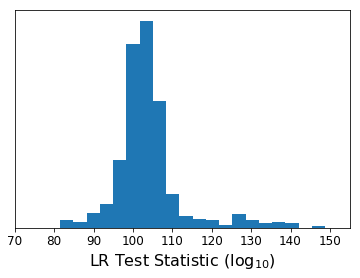

In [8]:
_ = plt.hist(numpy.log10(reseq.LRTest), bins=20)
_ = plt.xlim(70, 155)
_ = plt.yticks([])
_ = plt.xlabel(r'LR Test Statistic ($\log_{10}$)')

In [9]:
print(min(reseq.LRTest))
print(max(reseq.LRTest))

3.1951625041269066e+81
5.675786839158448e+148


In [10]:
samepop.head()

,ID,HaploPops,TestSample,HammingDist,LRTest
0,uMOxTAD,"MHDBP000077,MHDBP000077",RjuzDui,85,0.000000e+00
1,uMOxTAD,"MHDBP000077,MHDBP000077",rQFDlqD,88,0.000000e+00
2,uMOxTAD,"MHDBP000077,MHDBP000077",cksC3EM,72,7.675932e-168
3,rOAtSSp,"MHDBP000022,MHDBP000032",i4L0t4T,77,6.018047e-176
4,rOAtSSp,"MHDBP000022,MHDBP000032",OMOB2XC,79,6.018047e-179


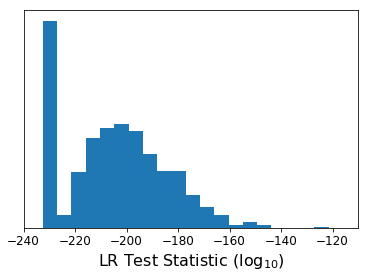

In [11]:
themin = numpy.log10(min([x for x in samepop.LRTest if x > 0.0]))
lrt = [numpy.log10(x) if x > 0.0 else themin for x in samepop.LRTest]
lrt = [x for x in lrt if x < 0.0]
_ = plt.hist(lrt, bins=20)
_ = plt.xlim(-240, -110)
_ = plt.yticks([])
_ = plt.xlabel(r'LR Test Statistic ($\log_{10}$)')

In [12]:
min([x for x in samepop.LRTest if x > 0.0])

2.697104485157545e-233

In [13]:
samepop[samepop.LRTest > 1.0]

,ID,HaploPops,TestSample,HammingDist,LRTest
850,rZQEBWU,"MHDBP000043,MHDBP000083",rZQEBWU,0,5.107112e+111
952,QAUIbRe,"MHDBP000042,MHDBP000065",QAUIbRe,0,2.915278e+119


In [14]:
max(samepop.LRTest)

2.9152779103307708e+119

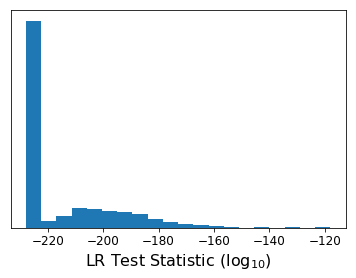

In [15]:
themin = numpy.log10(min([x for x in allpop.LRTest if x > 0.0]))
lrt = [numpy.log10(x) if x > 0.0 else themin for x in allpop.LRTest]
_ = plt.hist(lrt, bins=20)
#_ = plt.xlim(-240, -110)
_ = plt.yticks([])
_ = plt.xlabel(r'LR Test Statistic ($\log_{10}$)')

In [16]:
reseq_vals = numpy.log10(reseq.LRTest)
# Uh oh, two self-comparisons. Need to fix the simulation?
# lrt = [numpy.log10(x) if x > 0.0 else -245 for x in samepop.LRTest]
# samepop_vals = [x for x in lrt if x < 0.0]
samepop_vals = [numpy.log10(x) if x > 0.0 else -245 for x in samepop.LRTest]
allpop_vals = [numpy.log10(x) if x > 0.0 else -250 for x in allpop.LRTest]

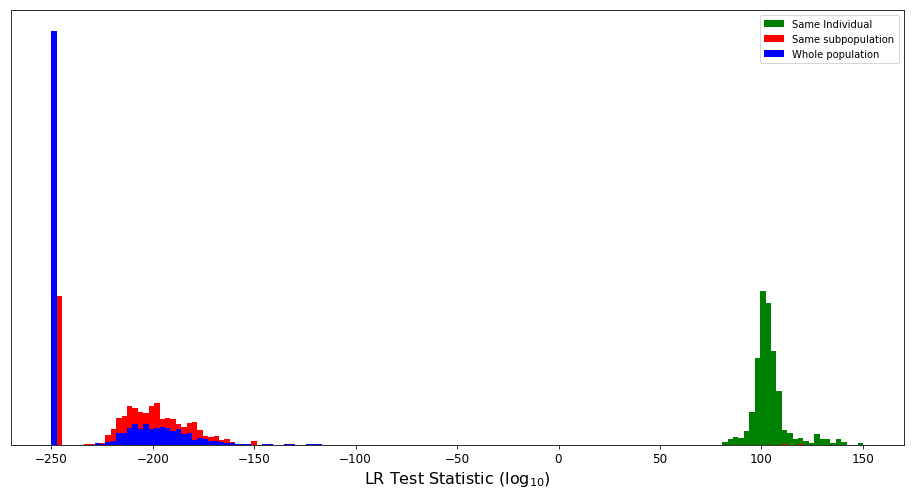

In [17]:
seaborn.set_context({"figure.figsize": (16, 8)})
_, bins, _ = plt.hist(reseq_vals, range=[-250, 150], color='green', bins=150, label='Same Individual')
_ = plt.hist(samepop_vals, bins=bins, color='red', label='Same subpopulation')
_ = plt.hist(allpop_vals, bins=bins, color='blue', label='Whole population')
_ = plt.yticks([])
_ = plt.xticks(range(-250, 151, 50))
_ = plt.xlabel(r'LR Test Statistic ($\log_{10}$)')
_ = plt.legend(loc='upper right')
_ = plt.savefig('sample-matching.pdf')
_ = plt.show()

In [18]:
list(range(-10, 10, 2))

[-10, -8, -6, -4, -2, 0, 2, 4, 6, 8]

In [19]:
numpy.log10(1e-250)

-250.0